In [101]:
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import lightkurve as lk

ticid = 460205581
sector = 10 #11
cadence='long'

if cadence=='short':
    res = lk.search_targetpixelfile(f'TIC {ticid}', mission='TESS', cadence='long')
    tpf = res.download(sector=sector)
else:
    tpf = lk.search_tesscut(f'TIC {ticid}', sector=sector).download(cutout_size=(50,50))

In [104]:
# Make an aperture mask and a raw light curve
aper = tpf.create_threshold_mask(3)
fluxes = tpf.flux
fluxes.shape

(1205, 50, 50)

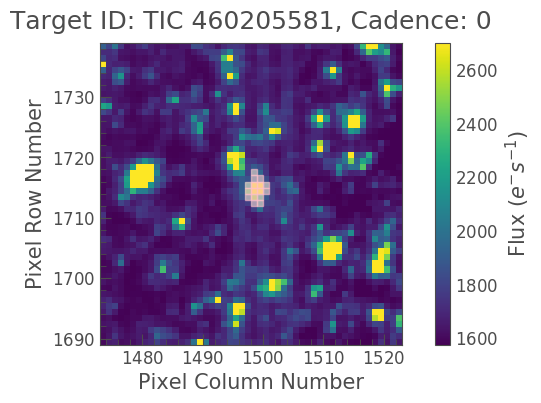

In [105]:
tpf.plot(aperture_mask=aper);

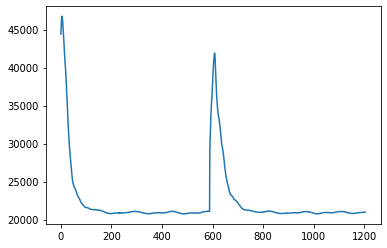

In [10]:
#raw_lc = tpf.to_lightcurve(aperture_mask=aper)
raw_lc = fluxes[:,aper].sum(axis=1)
pl.plot(raw_lc)

In [22]:
#out of mask
tpf.flux[:,~aper].shape

(1205, 2484)

## pca

In [106]:
#pca
Cov = np.cov(tpf.flux[:,~aper])
eig_vals, eig_vecs = np.linalg.eig(Cov)
eig_vals.shape, eig_vecs.shape

((1205,), (1205, 1205))

In [107]:
idx = eig_vals.argsort()
#get top 5
X = tpf.flux[:,~aper][:,idx][:5]

## bkg model

In [111]:
bkg_flux = tpf.flux[:,~aper].sum(axis=1)
A = X.dot(X.T)
B = bkg_flux.dot(X.T)
A[np.diag_indices_from(A)] += 1e-8
coeff = np.linalg.solve(A, B)
bkg_model = coeff.dot(X)

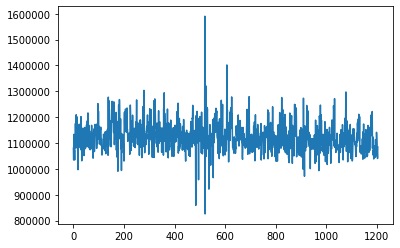

In [112]:
pl.plot(bkg_model)

## pld

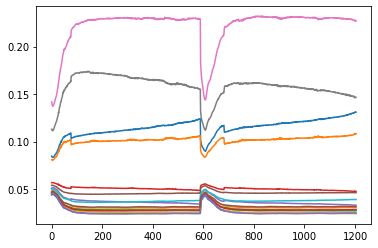

In [113]:
raw_flux = tpf.flux[:,aper].sum(axis=1)
basis_vectors = tpf.flux[:,aper]/raw_flux[:,np.newaxis]
pl.plot(basis_vectors);

In [114]:
X = basis_vectors.T
X.shape

(16, 1205)

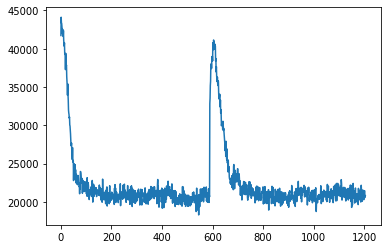

In [115]:
coeff = np.linalg.solve(X.dot(X.T), raw_flux.dot(X.T))
pld_model = coeff.dot(X)
pl.plot(pld_model)

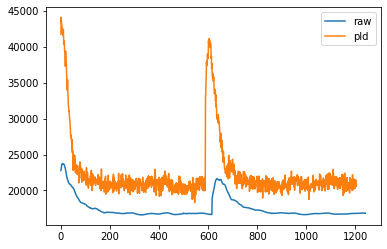

In [117]:
pl.plot(raw_lc.flux, label='raw')
# pl.plot(bkg_model, label='bkg')
pl.plot(pld_model, label='pld')
pl.legend()

## using lightkurve

In [120]:
tpf = tpf.cutout(size=10)
aper = tpf.create_threshold_mask()
raw_lc = tpf.to_lightcurve(aperture_mask=aper)

# Make a design matrix and pass it to a linear regression corrector
dm = lk.DesignMatrix(tpf.flux[:, ~aper], name='regressors').pca(5).append_constant()
rc = lk.RegressionCorrector(raw_lc)
corrected_lc = rc.correct(dm)

#Remove the scattered light from tpf, allowing for the large offset from scattered light
flux = tpf.flux[:, aper]-np.array(rc.model_lc.flux[:,np.newaxis, np.newaxis])

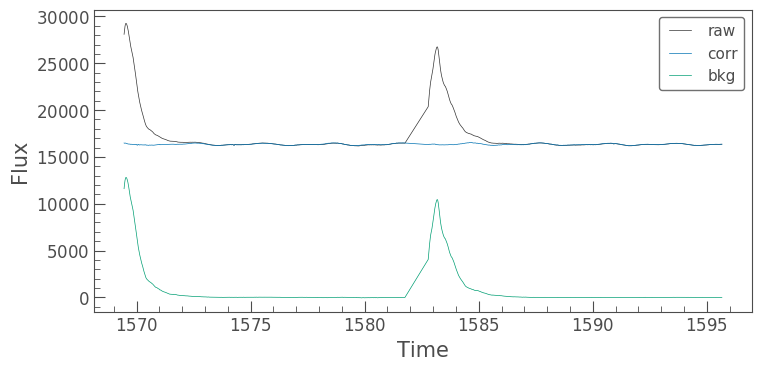

In [121]:
ax = raw_lc.plot(label='raw')
corrected_lc.plot(ax=ax, label='corr')
rc.model_lc.plot(ax=ax, label='bkg')

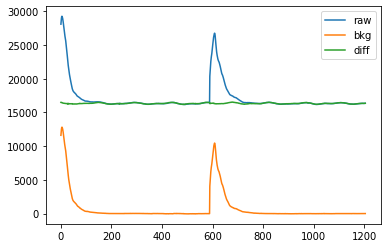

In [122]:
bkg_sub = raw_lc.flux-rc.model_lc.flux
pl.plot(raw_lc.flux, label='raw')
pl.plot(rc.model_lc.flux, label='bkg')
pl.plot(bkg_sub, label='diff')
pl.legend()

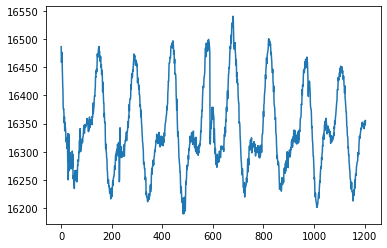

In [123]:
pl.plot(bkg_sub)

In [229]:
raw_flux = tpf.flux[:,aper].sum(axis=1)
tpf_bkg_sub = tpf.flux[:,aper]-rc.model_lc.flux[:,np.newaxis]/aper.sum()
tpf_bkg_sub.shape

(1205, 8)

In [232]:
raw_flux = tpf.flux[:,aper].sum(axis=1)
tpf_bkg_sub = tpf.flux[:,aper]-rc.model_lc.flux[:,np.newaxis]/aper.sum()
#normalize
basis_vectors = tpf_bkg_sub/raw_flux[:,np.newaxis]
basis_vectors.shape

(1205, 8)

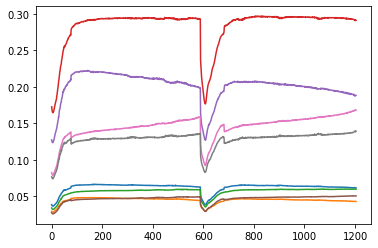

In [233]:
pl.plot(basis_vectors);

In [282]:
X = basis_vectors.T
A = X.dot(X.T)
B = bkg_sub.dot(X.T)
A[np.diag_indices_from(A)] += 1e-8
coeff = np.linalg.solve(A, B)
pld_model = coeff.dot(X)

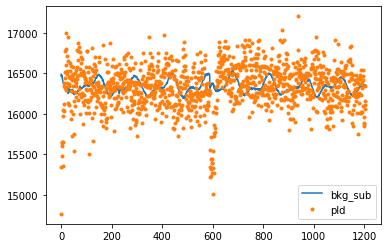

In [283]:
pl.plot(bkg_sub, label='bkg_sub')
pl.plot(pld_model, '.', label='pld')
pl.legend()

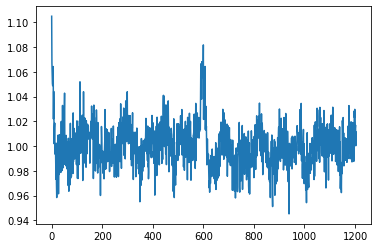

In [241]:
corr_lc = (bkg_sub-pld_model)+pld_model.mean()
pl.plot(corr_lc/np.median(pld_model))

In [315]:
import itertools
X = basis_vectors
X_aug = np.product(list(itertools.combinations_with_replacement(X.T, 2)), axis=1).T
X_aug.shape

(1205, 36)

In [316]:
X_poly = np.vander(np.linspace(0,1,X.shape[0]), 100)
X_poly.shape

(1205, 100)

In [317]:
X_sine = []
time = raw_lc.time
t = np.linspace(time.min(),time.max(),X.shape[0])
for phase in np.linspace(0, 2*np.pi, 10):
    for period in np.linspace(3, 30, 10):
        X_sine.append(np.sin(period*t-phase))
X_sine = np.array(X_sine).T
X_sine.shape

(1205, 100)

In [318]:
XX = np.c_[X_aug,X_poly,X_sine] #,np.ones_like(time)
XX.shape

(1205, 236)

In [319]:
A = XX.T.dot(XX)
B = bkg_sub.T.dot(XX)

coeff = np.linalg.solve(A, B)
model = coeff.dot(XX.T)

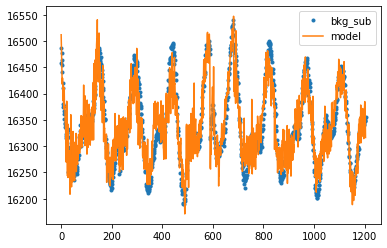

In [320]:
pl.plot(bkg_sub, '.', label='bkg_sub')
pl.plot(model, '-', label='model')
pl.legend()

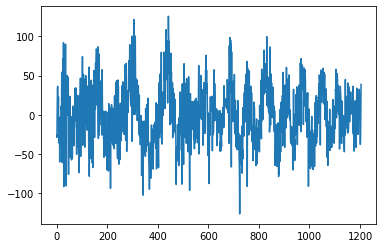

In [321]:
pl.plot(bkg_sub-model)

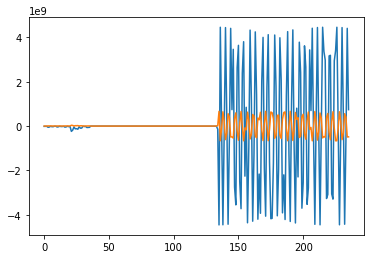

In [327]:
x1 = X_aug.shape[1]
x2 = x1+X_poly.shape[1]

for i in range(x1,x2,1)[:2]:
    pl.plot(np.dot(coeff[i],XX[i]), '-')

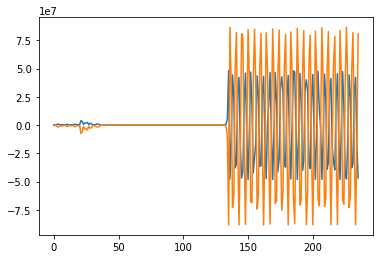

In [324]:
x3 = x2+X_poly.shape[1]

for i in range(x2,x3,1)[:2]:
    pl.plot(np.dot(coeff[i],XX[i]), '-')

* add polynomials in the design matrix
* add regularization; grid search
* optimize GP hyperparameters